In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore')

In [2]:
data_copy = pd.read_csv('clean_data.csv')
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527232 entries, 0 to 527231
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Origin                             527232 non-null  object
 1   Destination                        527232 non-null  object
 2   TTT                                527232 non-null  int64 
 3   LOS                                527232 non-null  int64 
 4   Arrival Time                       527232 non-null  object
 5   Return Arrival Time                527232 non-null  object
 6   Onward Departure Airport           527232 non-null  object
 7   Onward Arrival Airport             527232 non-null  object
 8   Return Departure Airport           527232 non-null  object
 9   Return Arrival Airport             527232 non-null  object
 10  Onward Airlines                    527232 non-null  object
 11  Return Airlines                    527232 non-null  

# Approach Determination

Since we cannot compare specific flights from one site to the other, we cannot directly calculation the difference in price between the sites,  
so we must tackle the situation with one of the following ways:

## 1️⃣Find Matching Flights Based on Similar Features
- In the absence of unique IDs, we can use a set of features to match flights from Kayak and Momondo.
- Features such as `Route` (`Origin` + `Destination`), `Airline` or any other categorical feature would help us match flights and compute the price difference. 

## 2️⃣Cluster-Based Approach
- For this approach, we group flights based on similar features and then match flights from both sites within the same cluster.
- K-Means Clustering can provide what we need for this method.

### Since we will explore Clustering in a different notebook, we decided to use the first approach this time.
___

# Price Difference Calculation

Our strategy will work as follows:
- For each site, we have 3 different snapshots, each consisting of 30 different TTT's and 5 different LOS options, for whom which we have about 100 records.
- For each combination we can calculate the avg/median price and compare it to the same metric for the other site.

## **Steps:**
1. Group each combination for each site.
2. Aggregate the relevent features based on what we beleive to be the best measure (mean/median/mode).
3. Seperate into 2 dataframes for each site and compute the difference in price between each combination.

In [3]:
print(data_copy.columns)

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Arrival Time',
       'Return Arrival Time', 'Onward Departure Airport',
       'Onward Arrival Airport', 'Return Departure Airport',
       'Return Arrival Airport', 'Onward Airlines', 'Return Airlines',
       'Onward Flight Connections', 'Onward Connection Duration(min)',
       'Onward Flight Connection Airport', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Return Flight Connection Airport',
       'Carry-ons', 'Checked Bags', 'Price(NIS)', 'Snapshot Date', 'Site',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Departure Weekday', 'Return Month', 'Return Day', 'Return Weekday',
       'Departure Time Category Num', 'Return Time Category Num',
       'Is Weekend Flight', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 

In [4]:
def mode_func(series):
    return series.mode()[0]

agg_df = data_copy.groupby(["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site"]).agg(
    {'Onward Departure Airport': mode_func,
    'Onward Arrival Airport': mode_func,
    'Return Departure Airport': mode_func,
    'Return Arrival Airport': mode_func,
    'Onward Airlines': mode_func,
    'Return Airlines': mode_func,
    'Onward Flight Connections': 'median',
    'Onward Connection Duration(min)': 'median',
    'Return Flight Connections': 'median',
    'Return Connection Duration(min)': 'median',
    'Carry-ons': mode_func,
    'Checked Bags': mode_func,
    'Total Onward Flight Duration(min)': 'median',
    'Total Return Flight Duration(min)': 'median',
    'Departure Month': mode_func,
    'Departure Day': mode_func,
    'Return Month': mode_func,
    'Return Day': mode_func,
    'Departure Time Category Num': 'median',
    'Return Time Category Num': 'median',
    'Onward Departure Airport Distance': 'mean',
    'Onward Arrival Airport Distance': 'mean',
    'Return Departure Airport Distance': 'mean',
    'Return Arrival Airport Distance': 'mean',
    'Price(NIS)': 'median'},
).reset_index()

agg_df.rename(columns={'Price(NIS)': 'Median Price (NIS)'}, inplace=True)

## ❗ We must note that for each site, the difference will be calculated by **the df site `-` the other site !**
📌 Be aware that this means that one df will have the same values as the other df but with the opisite sign.  
📌 We might later use the absolute value, but it is still important to remember who is subtracted by who. 

In [5]:
agg_df = agg_df.sort_values(by=["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site"]).reset_index(drop=True)
kayak_df = agg_df[agg_df['Site'] == 'Kayak'].copy().reset_index(drop=True)
momo_df = agg_df[agg_df['Site'] == 'Momondo'].copy().reset_index(drop=True)
momo_df["Price Difference"] = momo_df["Median Price (NIS)"] - kayak_df["Median Price (NIS)"]
kayak_df["Price Difference"] = kayak_df["Median Price (NIS)"] - momo_df["Median Price (NIS)"]
agg_df

,Origin,Destination,TTT,LOS,Snapshot Date,Site,Onward Departure Airport,Onward Arrival Airport,Return Departure Airport,Return Arrival Airport,...,Departure Day,Return Month,Return Day,Departure Time Category Num,Return Time Category Num,Onward Departure Airport Distance,Onward Arrival Airport Distance,Return Departure Airport Distance,Return Arrival Airport Distance,Median Price (NIS)
0,London,Paris,1,1,3/10/2025,Kayak,LGW,CDG,CDG,LGW,...,11,3,12,2.0,2.0,47.20,20.32,20.44,46.43,450.5
1,London,Paris,1,1,3/10/2025,Momondo,LTN,CDG,ORY,LGW,...,11,3,12,2.0,2.0,49.73,21.40,18.76,45.00,400.0
2,London,Paris,1,1,3/6/2025,Kayak,LGW,CDG,CDG,LGW,...,7,3,8,2.0,2.0,50.72,22.00,20.08,46.10,648.0
3,London,Paris,1,1,3/6/2025,Momondo,LGW,CDG,CDG,LGW,...,7,3,8,2.0,2.0,49.44,22.36,21.76,46.87,655.0
4,London,Paris,1,1,3/9/2025,Kayak,LGW,CDG,CDG,LGW,...,10,3,11,2.0,2.0,49.73,24.16,19.72,45.99,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,Rome,Paris,30,5,3/10/2025,Momondo,FCO,ORY,ORY,FCO,...,9,4,14,1.0,2.0,32.00,18.52,33.40,32.00,568.0
5396,Rome,Paris,30,5,3/6/2025,Kayak,FCO,ORY,ORY,FCO,...,5,4,10,1.0,2.0,32.00,24.52,27.88,32.00,625.5
5397,Rome,Paris,30,5,3/6/2025,Momondo,FCO,ORY,ORY,FCO,...,5,4,10,1.5,2.0,32.00,21.88,24.28,32.00,706.5
5398,Rome,Paris,30,5,3/9/2025,Kayak,FCO,ORY,ORY,FCO,...,8,4,13,2.0,3.0,32.00,20.56,23.44,32.00,732.0


In [6]:
kayak_df.tail()

,Origin,Destination,TTT,LOS,Snapshot Date,Site,Onward Departure Airport,Onward Arrival Airport,Return Departure Airport,Return Arrival Airport,...,Return Month,Return Day,Departure Time Category Num,Return Time Category Num,Onward Departure Airport Distance,Onward Arrival Airport Distance,Return Departure Airport Distance,Return Arrival Airport Distance,Median Price (NIS),Price Difference
2695,Rome,Paris,30,4,3/6/2025,Kayak,FCO,ORY,ORY,FCO,...,4,9,1.0,1.0,32.0,21.640000,23.08000,32.0,554.0,-56.5
2696,Rome,Paris,30,4,3/9/2025,Kayak,FCO,ORY,ORY,FCO,...,4,12,2.0,1.0,32.0,19.461538,19.32967,32.0,826.0,-23.0
2697,Rome,Paris,30,5,3/10/2025,Kayak,FCO,ORY,ORY,FCO,...,4,14,1.0,2.0,32.0,18.760000,31.00000,32.0,542.0,-26.0
2698,Rome,Paris,30,5,3/6/2025,Kayak,FCO,ORY,ORY,FCO,...,4,10,1.0,2.0,32.0,24.520000,27.88000,32.0,625.5,-81.0
2699,Rome,Paris,30,5,3/9/2025,Kayak,FCO,ORY,ORY,FCO,...,4,13,2.0,3.0,32.0,20.560000,23.44000,32.0,732.0,-73.0


In [7]:
momo_df.tail()

,Origin,Destination,TTT,LOS,Snapshot Date,Site,Onward Departure Airport,Onward Arrival Airport,Return Departure Airport,Return Arrival Airport,...,Return Month,Return Day,Departure Time Category Num,Return Time Category Num,Onward Departure Airport Distance,Onward Arrival Airport Distance,Return Departure Airport Distance,Return Arrival Airport Distance,Median Price (NIS),Price Difference
2695,Rome,Paris,30,4,3/6/2025,Momondo,FCO,ORY,ORY,FCO,...,4,9,1.0,1.0,32.0,18.04,22.96,32.0,610.5,56.5
2696,Rome,Paris,30,4,3/9/2025,Momondo,FCO,ORY,ORY,FCO,...,4,12,2.0,3.0,32.0,19.75,17.50,32.0,849.0,23.0
2697,Rome,Paris,30,5,3/10/2025,Momondo,FCO,ORY,ORY,FCO,...,4,14,1.0,2.0,32.0,18.52,33.40,32.0,568.0,26.0
2698,Rome,Paris,30,5,3/6/2025,Momondo,FCO,ORY,ORY,FCO,...,4,10,1.5,2.0,32.0,21.88,24.28,32.0,706.5,81.0
2699,Rome,Paris,30,5,3/9/2025,Momondo,FCO,ORY,ORY,FCO,...,4,13,2.0,2.0,32.0,19.48,31.96,32.0,805.0,73.0


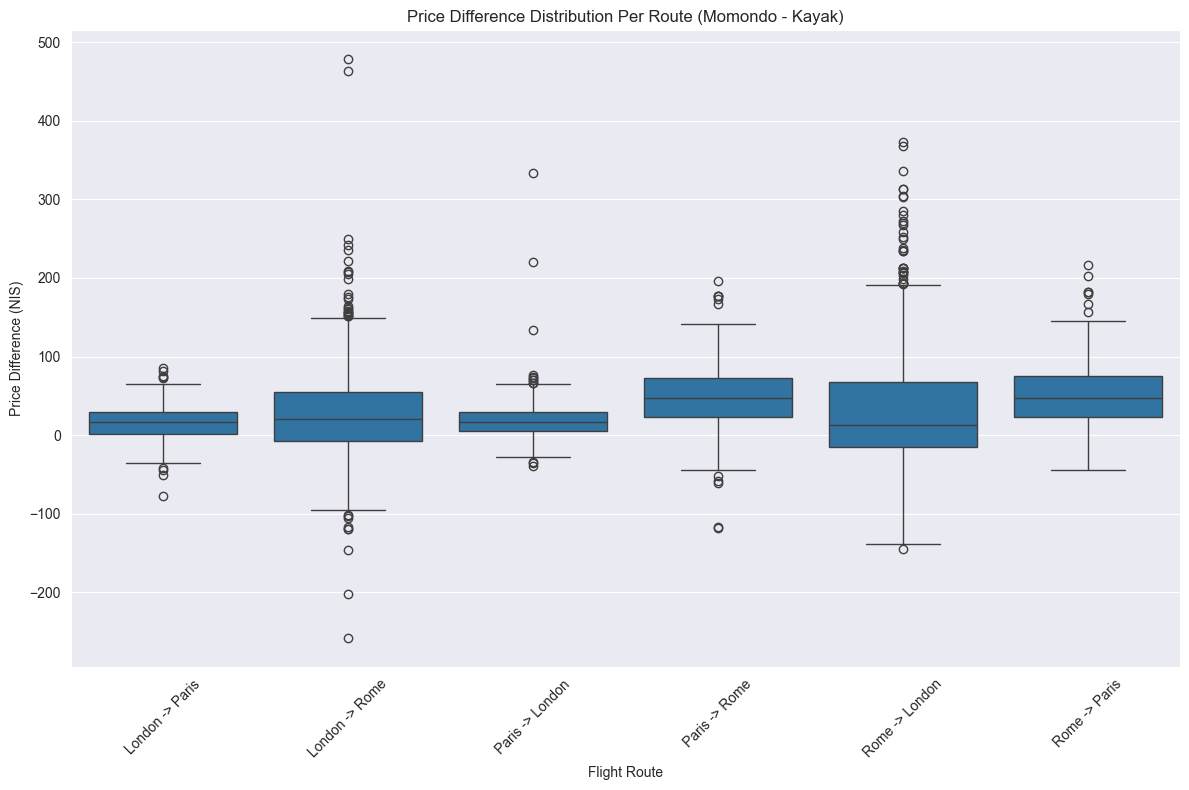

In [8]:
kayak_df["Route"] = kayak_df["Origin"] + " -> " + kayak_df["Destination"]
momo_df["Route"] = momo_df["Origin"] + " -> " + momo_df["Destination"]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the box plots
sns.boxplot(data=momo_df, x="Route", y="Price Difference", showfliers=True)

# Customize labels for each subplot
plt.title("Price Difference Distribution Per Route (Momondo - Kayak)")

plt.xlabel("Flight Route")
plt.ylabel("Price Difference (NIS)")
plt.tick_params(axis='x', rotation=45)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

- Each route has different pricing dynamics, so separate models might capture trends better.

- However this will force us to apply algorithm's on 12 different sub-sets, as well as reduce the amount of data for each subset.

- Even though many outliers are priced differently for each route, the main pricing dynamic acts around the same ranges,  
so we can keep them together and scale the data in order to handle drastic noise if needed.
___

### One-Hot Encoding for the `Route` Column

Since machine learning models cannot process categorical variables directly, we apply **One-Hot Encoding** to convert this column into separate binary columns (also known as 'Dummy Variables').

Keeping the `Route` column as a numeric variable would incorrectly imply an ordinal relationship between sites. One-Hot Encoding ensures the model treats each site as an independent feature, preventing unintended biases and allowing it to capture potential differences in price variations between routes.

__________

In [9]:
kayak_df = pd.get_dummies(kayak_df, columns=['Route'])
momo_df = pd.get_dummies(momo_df, columns=['Route'])

In [10]:
kayak_df.columns

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Snapshot Date', 'Site',
       'Onward Departure Airport', 'Onward Arrival Airport',
       'Return Departure Airport', 'Return Arrival Airport', 'Onward Airlines',
       'Return Airlines', 'Onward Flight Connections',
       'Onward Connection Duration(min)', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Carry-ons', 'Checked Bags',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Return Month', 'Return Day', 'Departure Time Category Num',
       'Return Time Category Num', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 'Median Price (NIS)',
       'Price Difference', 'Route_London -> Paris', 'Route_London -> Rome',
       'Route_Paris -> London', 'Route_Paris -> Rome', 'Route_Rome -> London',
       'Route_Rome -> Paris']

### Dropping features that won't serve us any value:

In [11]:
kayak_df.drop(columns=(['Origin', 'Destination', 'Snapshot Date', 'Site']), axis=1, inplace=True)

In [12]:
kayak_df.dtypes

TTT                                    int64
LOS                                    int64
Onward Departure Airport              object
Onward Arrival Airport                object
Return Departure Airport              object
Return Arrival Airport                object
Onward Airlines                       object
Return Airlines                       object
Onward Flight Connections            float64
Onward Connection Duration(min)      float64
Return Flight Connections            float64
Return Connection Duration(min)      float64
Carry-ons                              int64
Checked Bags                           int64
Total Onward Flight Duration(min)    float64
Total Return Flight Duration(min)    float64
Departure Month                        int64
Departure Day                          int64
Return Month                           int64
Return Day                             int64
Departure Time Category Num          float64
Return Time Category Num             float64
Onward Dep

### We will first practice on Kayak and later on Momondo to avoid confusion

In [13]:
kayak_df = pd.get_dummies(kayak_df, columns=['Onward Departure Airport', 'Onward Arrival Airport', 'Return Departure Airport', 'Return Arrival Airport', 'Onward Airlines', 'Return Airlines'])

In [14]:
print(kayak_df['Price Difference'].isna().value_counts())
print(momo_df['Price Difference'].isna().value_counts())

Price Difference
False    2700
Name: count, dtype: int64
Price Difference
False    2700
Name: count, dtype: int64


In [15]:
Xk = kayak_df.drop(['Price Difference'], axis = 1)
yk = kayak_df['Price Difference']

X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)

print(X_trainK.shape)
print(X_testK.shape)

(1890, 75)
(810, 75)


## Baseline models with all features and default parameters
### Just so that we have an initial indicator of our statring point.

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [17]:
gbr = GradientBoostingRegressor(random_state=101)

gbr.fit(X_trainK, y_trainK)

preds1 = gbr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds1), 3)
r2_score_all

0.211

In [18]:
knn = KNeighborsRegressor()

knn.fit(X_trainK, y_trainK)

preds2 = knn.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds2), 3)
r2_score_all

0.049

In [19]:
xgb = XGBRegressor(random_state=101)

xgb.fit(X_trainK, y_trainK)

preds3 = xgb.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds3), 3)
r2_score_all


0.131

In [20]:
dtr = DecisionTreeRegressor(random_state=101)

dtr.fit(X_trainK, y_trainK)

preds4 = dtr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds4), 3)
r2_score_all


-0.523

In [21]:
rfr = RandomForestRegressor(random_state=101)

rfr.fit(X_trainK, y_trainK)

preds5 = rfr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds5), 3)
r2_score_all

0.21

## The starting points scores are **VERY low**.
### Perhaps we are under-fitting with not enough information to feed the algorithm's.
### We will try aggregating based on groups of 10 instead of 100 and see if results improve.

In [22]:
def mode_func(series):
    return series.mode()[0]

# 1. Perform the initial grouping without aggregating yet
agg_df = data_copy.groupby(
    ["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site"]
).apply(lambda group: group.reset_index(drop=True))

# 2. Since we reset the index for each group, we can now handle the "Subgroup" creation
agg_df = agg_df.reset_index(drop=True)

# 3. Add a "Subgroup" column to divide 100 records into 10 groups (each with 10 records)
agg_df["Subgroup"] = agg_df.groupby(
    ["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site"]
).cumcount() // 10 + 1

# 4. Now aggregate each group of 10 records into 1
final_agg_df = agg_df.groupby(
    ["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site", "Subgroup"]
).agg(
    {
        'Onward Departure Airport': mode_func,
        'Onward Arrival Airport': mode_func,
        'Return Departure Airport': mode_func,
        'Return Arrival Airport': mode_func,
        'Onward Airlines': mode_func,
        'Return Airlines': mode_func,
        'Onward Flight Connections': 'median',
        'Onward Connection Duration(min)': 'median',
        'Return Flight Connections': 'median',
        'Return Connection Duration(min)': 'median',
        'Carry-ons': mode_func,
        'Checked Bags': mode_func,
        'Total Onward Flight Duration(min)': 'median',
        'Total Return Flight Duration(min)': 'median',
        'Departure Month': mode_func,
        'Departure Day': mode_func,
        'Return Month': mode_func,
        'Return Day': mode_func,
        'Departure Time Category Num': 'median',
        'Return Time Category Num': 'median',
        'Onward Departure Airport Distance': 'mean',
        'Onward Arrival Airport Distance': 'mean',
        'Return Departure Airport Distance': 'mean',
        'Return Arrival Airport Distance': 'mean',
        'Price(NIS)': 'median'
    }
).reset_index()

final_agg_df.rename(columns={'Price(NIS)': 'Median Price (NIS)'}, inplace=True)

final_agg_df.shape

(53039, 32)

In [54]:
final_agg_df = final_agg_df.sort_values(by=["Origin", "Destination", "TTT", "LOS", "Snapshot Date", "Site"]).reset_index(drop=True)
kayak_df = final_agg_df[final_agg_df['Site'] == 'Kayak'].copy().reset_index(drop=True)
momo_df = final_agg_df[final_agg_df['Site'] == 'Momondo'].copy().reset_index(drop=True)
momo_df["Price Difference"] = momo_df["Median Price (NIS)"] - kayak_df["Median Price (NIS)"]
kayak_df["Price Difference"] = kayak_df["Median Price (NIS)"] - momo_df["Median Price (NIS)"]

final_agg_df

,Origin,Destination,TTT,LOS,Snapshot Date,Site,Subgroup,Onward Departure Airport,Onward Arrival Airport,Return Departure Airport,...,Departure Day,Return Month,Return Day,Departure Time Category Num,Return Time Category Num,Onward Departure Airport Distance,Onward Arrival Airport Distance,Return Departure Airport Distance,Return Arrival Airport Distance,Median Price (NIS)
0,London,Paris,1,1,3/10/2025,Kayak,1,LTN,CDG,CDG,...,11,3,12,1.5,2.0,56.0,25.0,25.0,56.0,371.0
1,London,Paris,1,1,3/10/2025,Kayak,2,LTN,CDG,CDG,...,11,3,12,2.0,1.5,51.6,23.8,22.6,42.8,405.0
2,London,Paris,1,1,3/10/2025,Kayak,3,LTN,CDG,ORY,...,11,3,12,2.0,2.0,49.4,21.4,16.6,35.1,410.0
3,London,Paris,1,1,3/10/2025,Kayak,4,LTN,CDG,ORY,...,11,3,12,2.0,1.0,51.6,22.6,17.8,46.1,433.5
4,London,Paris,1,1,3/10/2025,Kayak,5,LGW,CDG,CDG,...,11,3,12,2.0,3.0,49.4,19.0,20.2,47.2,456.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53034,Rome,Paris,30,5,3/9/2025,Momondo,6,FCO,ORY,BVA,...,8,4,13,1.0,2.0,32.0,27.4,45.4,32.0,677.0
53035,Rome,Paris,30,5,3/9/2025,Momondo,7,FCO,ORY,ORY,...,8,4,13,1.0,1.5,32.0,31.0,31.0,32.0,838.5
53036,Rome,Paris,30,5,3/9/2025,Momondo,8,FCO,ORY,ORY,...,8,4,13,1.5,2.5,32.0,28.6,31.0,32.0,825.0
53037,Rome,Paris,30,5,3/9/2025,Momondo,9,FCO,ORY,ORY,...,8,4,13,2.0,2.5,32.0,14.2,29.8,32.0,688.0


In [55]:
kayak_df["Route"] = kayak_df["Origin"] + " -> " + kayak_df["Destination"]
momo_df["Route"] = momo_df["Origin"] + " -> " + momo_df["Destination"]
kayak_df = pd.get_dummies(kayak_df, columns=['Route'])
momo_df = pd.get_dummies(momo_df, columns=['Route'])
kayak_df.drop(columns=(['Origin', 'Destination', 'Snapshot Date', 'Site', 'Subgroup']), axis=1, inplace=True)
momo_df.drop(columns=(['Origin', 'Destination', 'Snapshot Date', 'Site', 'Subgroup']), axis=1, inplace=True)
kayak_df = pd.get_dummies(kayak_df, columns=['Onward Departure Airport', 'Onward Arrival Airport', 'Return Departure Airport', 'Return Arrival Airport', 'Onward Airlines', 'Return Airlines'])
momo_df = pd.get_dummies(momo_df, columns=['Onward Departure Airport', 'Onward Arrival Airport', 'Return Departure Airport', 'Return Arrival Airport', 'Onward Airlines', 'Return Airlines'])

In [25]:
print(kayak_df['Price Difference'].isna().value_counts())
print(momo_df['Price Difference'].isna().value_counts())

Price Difference
False    26390
True       259
Name: count, dtype: int64
Price Difference
False    26390
Name: count, dtype: int64


In [56]:
kayak_df.dropna(subset=['Price Difference'], inplace=True)

In [27]:
Xk = kayak_df.drop(['Price Difference'], axis = 1)
yk = kayak_df['Price Difference']

# reseting trained variables
X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)

print(X_trainK.shape)
print(X_testK.shape)

(18473, 92)
(7917, 92)


In [28]:
gbr = GradientBoostingRegressor(random_state=101)

gbr.fit(X_trainK, y_trainK)

preds1 = gbr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds1), 3)
r2_score_all

0.537

In [29]:
knn = KNeighborsRegressor()

knn.fit(X_trainK, y_trainK)

preds2 = knn.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds2), 3)
r2_score_all

0.467

In [30]:
xgb = XGBRegressor(random_state=101)

xgb.fit(X_trainK, y_trainK)

preds3 = xgb.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds3), 3)
r2_score_all


0.631

In [31]:
dtr = DecisionTreeRegressor(random_state=101)

dtr.fit(X_trainK, y_trainK)

preds4 = dtr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds4), 3)
r2_score_all

0.244

In [32]:
rfr = RandomForestRegressor(random_state=101)

rfr.fit(X_trainK, y_trainK)

preds5 = rfr.predict(X_testK)

r2_score_all = round(r2_score(y_testK, preds5), 3)
r2_score_all

0.622

## Clear signs of improvment with more data.
### We will continue using aggregation based on groups of 10.
___

# **Feature Selection**

### Using various methods to 'filter out' non-benefitial features in order to improve performance and reduce unnecessary features.

#### 📌 Note - We will only test feature selection using Random Forrest algorithm and then apply it's outcome to all other algorithm's.
___

### Method 1: **Variance Threshold**

In [33]:
X_trainK.var(axis=0).sort_values(ascending=False)

Median Price (NIS)                   38571.838054
Total Onward Flight Duration(min)     1257.768189
Total Return Flight Duration(min)     1198.967491
Return Departure Airport Distance      178.592605
Onward Departure Airport Distance      174.081827
                                         ...     
Onward Airlines_Iberia                   0.000271
Return Arrival Airport_SEN               0.000216
Return Airlines_Tunisair                 0.000108
Onward Airlines_Tunisair                 0.000054
Return Departure Airport_LCY             0.000000
Length: 92, dtype: float64

#### Cheking if our DF has any negative values to determine if we use MinMaxScaler or StandardScaler:

In [34]:
(Xk < 0).any().any()

np.False_

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_trainK = scaler.fit_transform(X_trainK)

scaled_X_trainK = pd.DataFrame(scaled_X_trainK, columns=X_trainK.columns)

# Compute and sort variance
sorted_variance = scaled_X_trainK.var(axis=0).sort_values(ascending=False)

sorted_variance.tail(30)

Return Airlines_ITA Airways          0.015296
Carry-ons                            0.013087
Total Return Flight Duration(min)    0.012083
Return Departure Airport_LHR         0.010551
Return Departure Airport_BVA         0.009650
Total Onward Flight Duration(min)    0.009441
Onward Departure Airport_BVA         0.009225
Onward Departure Airport_LHR         0.008587
Onward Airlines_Jet2                 0.007575
Return Arrival Airport_LHR           0.007522
Onward Arrival Airport_LHR           0.007095
Return Arrival Airport_BVA           0.006240
Return Airlines_Jet2                 0.006187
Onward Arrival Airport_BVA           0.005545
Onward Flight Connections            0.001635
Return Departure Airport_SEN         0.001514
Onward Departure Airport_SEN         0.001190
Onward Arrival Airport_LCY           0.001028
Onward Connection Duration(min)      0.000945
Return Flight Connections            0.000784
Return Connection Duration(min)      0.000557
Return Arrival Airport_LCY        

#### We set our variance treshold at 0.01 so any feature with lower variance will be droped:

In [36]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.01
selector = VarianceThreshold(threshold=threshold)
selector.fit(scaled_X_trainK)

over_thresh_features = X_trainK.columns[selector.get_support()]
dropped_features = list(set(X_trainK.columns) - set(over_thresh_features))

# keep only features over the threshold
X_trainK_var = X_trainK[over_thresh_features]
X_testK_var = X_testK[over_thresh_features]

X_trainK.shape


(18473, 92)

In [37]:
rfr.fit(X_trainK_var, y_trainK)

var_preds = rfr.predict(X_testK_var)

r2_score_all = round(r2_score(y_testK, var_preds), 3)
r2_score_all

0.623

#### Our score has barely increased but we still reduced features so it is a good starting point and we will implement this on our data.

In [38]:
X_trainK = X_trainK_var
X_testK = X_testK_var

### Method 2: **Random Forrest Feature Importance**

In [39]:
X_trainK.shape

(18473, 66)

In [40]:
important_features_rf = pd.DataFrame({"Feature": X_trainK.columns, "Importance": rfr.feature_importances_ })
important_features_rf = important_features_rf.sort_values(by="Importance", ascending=False)
important_features_rf.head(20)

,Feature,Importance
14,Median Price (NIS),0.449021
0,TTT,0.102816
3,Total Return Flight Duration(min),0.067998
5,Departure Day,0.060069
7,Return Day,0.048019
12,Return Departure Airport Distance,0.032710
10,Onward Departure Airport Distance,0.032710
13,Return Arrival Airport Distance,0.032172
11,Onward Arrival Airport Distance,0.030582
1,LOS,0.028699


In [41]:
threshold = 0.01
over_thresh_features = important_features_rf[important_features_rf["Importance"] >= threshold]["Feature"]
dropped_features = list(set(X_trainK.columns) - set(over_thresh_features))

X_trainK_fi = X_trainK[over_thresh_features]
X_testK_fi = X_testK[over_thresh_features]

X_trainK_fi.shape

(18473, 12)

In [42]:
rfr.fit(X_trainK_fi, y_trainK)

fi_preds = rfr.predict(X_testK_fi)

r2_score_all = round(r2_score(y_testK, fi_preds), 3)
r2_score_all

0.627

#### Score has slightly risen so we will implement the changes on our data.

In [43]:
X_trainK = X_trainK_fi
X_testK = X_testK_fi

### Method 3: **Correlation With Target**

In [44]:
X_testK.columns

Index(['Median Price (NIS)', 'TTT', 'Total Return Flight Duration(min)',
       'Departure Day', 'Return Day', 'Return Departure Airport Distance',
       'Onward Departure Airport Distance', 'Return Arrival Airport Distance',
       'Onward Arrival Airport Distance', 'LOS', 'Return Time Category Num',
       'Departure Time Category Num'],
      dtype='object')

In [45]:
train_data = pd.concat([X_trainK, y_trainK], axis=1)

correlation_with_target = train_data.corr()[y_trainK.name].drop(y_trainK.name)  # Drop target itself
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

correlation_with_target

Median Price (NIS)                   0.486207
TTT                                  0.108109
Return Day                           0.073314
Departure Time Category Num          0.050429
Departure Day                        0.049189
Return Departure Airport Distance    0.038591
Return Time Category Num             0.024627
Return Arrival Airport Distance      0.021740
LOS                                  0.010144
Onward Arrival Airport Distance      0.008748
Total Return Flight Duration(min)    0.005397
Onward Departure Airport Distance    0.002163
Name: Price Difference, dtype: float64

In [46]:
threshold = 0.01
over_thresh_features = correlation_with_target[correlation_with_target >= threshold].index
dropped_features = list(set(X_trainK.columns) - set(over_thresh_features))

X_trainK_cor = X_trainK[over_thresh_features]
X_testK_cor = X_testK[over_thresh_features]

X_trainK.shape

(18473, 12)

In [47]:
rfr.fit(X_trainK_cor, y_trainK)

cor_preds = rfr.predict(X_testK_cor)

r2_score_all = round(r2_score(y_testK, cor_preds), 3)
r2_score_all

0.609

#### Score has gone down so we won't implement this method on our data.

### Method 4: **K-Best Features**

📌 Note - We can also use RFE instead but RFE suits the data based on the specific algorithm while this method does not.  
Because we will later try different algo's then its best to the most general approach as possible. 

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

r2_score_list = []

for k in range(1, 13):
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X_trainK, y_trainK)
    
    sel_X_trainK = selector.transform(X_trainK)
    sel_X_testK = selector.transform(X_testK)
    
    rfr.fit(sel_X_trainK, y_trainK)
    kbest_preds = rfr.predict(sel_X_testK)
    
    r2_score_kbest = round(r2_score(y_testK, kbest_preds), 3)
    
    r2_score_list.append(r2_score_kbest)
    print(k)
    print(r2_score_kbest)
    print()

1
0.229

2
0.272

3
0.311

4
0.358

5
0.377

6
0.395

7
0.52

8
0.55

9
0.615

10
0.614

11
0.616

12
0.627



In [49]:
max_r2_score = max(r2_score_list)
print(max_r2_score)

0.627


#### All current features provide the best score for our model so we will keep them.

In [50]:
X_trainK.columns

Index(['Median Price (NIS)', 'TTT', 'Total Return Flight Duration(min)',
       'Departure Day', 'Return Day', 'Return Departure Airport Distance',
       'Onward Departure Airport Distance', 'Return Arrival Airport Distance',
       'Onward Arrival Airport Distance', 'LOS', 'Return Time Category Num',
       'Departure Time Category Num'],
      dtype='object')

In [59]:
kayak_df = kayak_df[['Median Price (NIS)', 'TTT', 'Total Return Flight Duration(min)',
       'Departure Day', 'Return Day', 'Return Departure Airport Distance',
       'Onward Departure Airport Distance', 'Return Arrival Airport Distance',
       'Onward Arrival Airport Distance', 'LOS', 'Return Time Category Num',
       'Departure Time Category Num', 'Price Difference']]

momo_df = momo_df[['Median Price (NIS)', 'TTT', 'Total Return Flight Duration(min)',
       'Departure Day', 'Return Day', 'Return Departure Airport Distance',
       'Onward Departure Airport Distance', 'Return Arrival Airport Distance',
       'Onward Arrival Airport Distance', 'LOS', 'Return Time Category Num',
       'Departure Time Category Num', 'Price Difference']]

___
### Now that we have selected our most relevent features, we will train different algorithm's on each site's DF to try and best predict.

#### We will be testing XGBoost, Gradiant Boosting and Random Forrest as our algorithm's because they got the initial highest scores and are considered quick (important because we will need to run multiple algo's).

- Tree based algo's such as the ones we will use, unlike distance based algo's, don't need scalling.
- We will use the hyperparameters that were used on our previous notebooks. 

In [ ]:
Xk = kayak_df.drop(['Price Difference'], axis = 1)
yk = kayak_df['Price Difference']
Xm = momo_df.drop(['Price Difference'], axis = 1)
ym = momo_df['Price Difference']

In [65]:
# reseting trained variables and adding new ones for second df
X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)
X_trainM, X_testM, y_trainM, y_testM = train_test_split(Xm, ym, test_size=0.3, random_state=101)

In [66]:
from sklearn.model_selection import GridSearchCV

## **Random Forrest**

In [68]:
# Defining parameter grid for tuning
param_grid_rf = {
    'n_estimators': [50, 100],  # Fewer estimators to balance performance and speed
    'max_depth': [10, None],  # Limit depth to prevent overfitting
    'min_samples_split': [5, 10]  # Minimum samples required to split a node
}

# Running GridSearchCV
grid_search_rf1 = GridSearchCV(
    RandomForestRegressor(random_state=101, n_jobs=-1), 
    param_grid_rf, cv=3, n_jobs=-1, verbose=1
)
grid_search_rf2 = GridSearchCV(
    RandomForestRegressor(random_state=101, n_jobs=-1), 
    param_grid_rf, cv=3, n_jobs=-1, verbose=1
)

# Fitting the GridSearchCV
grid_search_rf1.fit(X_trainK, y_trainK)
grid_search_rf2.fit(X_trainM, y_trainM)

# Displaying best parameters
print(f"Best parameters for Kayak: {grid_search_rf1.best_params_}")
print()
print(f"Best parameters for Momondo: {grid_search_rf2.best_params_}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Kayak: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Best parameters for Momondo: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
best_K_rf = grid_search_rf1.best_estimator_
y_pred_best_K_rf = best_K_rf.predict(X_testK)
best_M_rf = grid_search_rf2.best_estimator_
y_pred_best_M_rf = best_M_rf.predict(X_testM)

r2K = r2_score(y_testK, y_pred_best_K_rf)
r2M = r2_score(y_testM, y_pred_best_M_rf)

print(f"Optimized Kayak Random Forest - R²: {r2K:.4f}")
print(f"Optimized Momondo Random Forest - R²: {r2M:.4f}")

Optimized K Random Forest - R²: 0.6254
Optimized M Random Forest - R²: 0.5049


In [72]:
# reseting trained variables
X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)
X_trainM, X_testM, y_trainM, y_testM = train_test_split(Xm, ym, test_size=0.3, random_state=101)

## **XGBoost**

In [73]:
# Defining parameter grid for tuning
param_grid_xg = {
    'n_estimators': [100, 200, 500],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0], 
    'gamma':[0,0.15],
    'min_child_weight': [1, 3] 
}

# Running GridSearchCV
grid_search_xg1 = GridSearchCV(
    XGBRegressor(random_state=101, n_jobs=-1), 
    param_grid_xg, cv=3, n_jobs=-1, verbose=1
)
grid_search_xg2 = GridSearchCV(
    XGBRegressor(random_state=101, n_jobs=-1), 
    param_grid_xg, cv=3, n_jobs=-1, verbose=1
)

# Fitting the GridSearchCV
grid_search_xg1.fit(X_trainK, y_trainK)
grid_search_xg2.fit(X_trainM, y_trainM)

# Displaying best parameters
print(f"Best parameters for Kayak: {grid_search_xg1.best_params_}")
print()
print(f"Best parameters for Momondo: {grid_search_xg2.best_params_}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters for Kayak: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best parameters for Momondo: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}


In [ ]:
best_K_xg = grid_search_xg1.best_estimator_
y_pred_best_K_xg = best_K_xg.predict(X_testK)
best_M_xg = grid_search_xg2.best_estimator_
y_pred_best_M_xg = best_M_xg.predict(X_testM)

r2K = r2_score(y_testK, y_pred_best_K_xg)
r2M = r2_score(y_testM, y_pred_best_M_xg)

print(f"Optimized Kayak XGBoost - R²: {r2K:.4f}")
print(f"Optimized Momondo XGBoost - R²: {r2M:.4f}")

Optimized K XGBoost - R²: 0.6523
Optimized M XGBoost - R²: 0.5073


In [75]:
# reseting trained variables
X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)
X_trainM, X_testM, y_trainM, y_testM = train_test_split(Xm, ym, test_size=0.3, random_state=101)

## **Gradient Boosting**

In [78]:
# Defining parameter grid for tuning
param_grid_gb = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.7, 0.9]
}

# Running GridSearchCV
grid_search_gb1 = GridSearchCV(
    GradientBoostingRegressor(random_state=101), 
    param_grid_gb, cv=3, n_jobs=-1, verbose=1
)
grid_search_gb2 = GridSearchCV(
    GradientBoostingRegressor(random_state=101), 
    param_grid_gb, cv=3, n_jobs=-1, verbose=1
)

# Fitting the GridSearchCV
grid_search_gb1.fit(X_trainK, y_trainK)
grid_search_gb2.fit(X_trainM, y_trainM)

# Displaying best parameters
print(f"Best parameters for Kayak: {grid_search_gb1.best_params_}")
print()
print(f"Best parameters for Momondo: {grid_search_gb2.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters for Kayak: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 700, 'subsample': 0.9}

Best parameters for Momondo: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


In [79]:
best_K_gb = grid_search_gb1.best_estimator_
y_pred_best_K_gb = best_K_gb.predict(X_testK)
best_M_gb = grid_search_gb2.best_estimator_
y_pred_best_M_gb = best_M_gb.predict(X_testM)

r2K = r2_score(y_testK, y_pred_best_K_gb)
r2M = r2_score(y_testM, y_pred_best_M_gb)

print(f"Optimized Kayak Gradient Boosting - R²: {r2K:.4f}")
print(f"Optimized Momondo Gradient Boosting - R²: {r2M:.4f}")

Optimized Kayak Gradient Boosting - R²: 0.6589
Optimized Momondo Gradient Boosting - R²: 0.5179


In [94]:
# reseting trained variables
X_trainK, X_testK, y_trainK, y_testK = train_test_split(Xk, yk, test_size=0.3, random_state=101)
X_trainM, X_testM, y_trainM, y_testM = train_test_split(Xm, ym, test_size=0.3, random_state=101)

### We can conclude that Gradient Boosting is the most suitable algorithm for our data, even though our R2 score is not good at all. 

In [97]:
y_pred_kayak = grid_search_gb1.best_estimator_.predict(X_testK)

mseK = mean_squared_error(y_testK, y_pred_kayak)
r2K = r2_score(y_testK, y_pred_kayak)
maeK = mean_absolute_error(y_testK, y_pred_kayak)
rmseK = np.sqrt(mseK)

print(f"Kayak - MSE: {mseK:.2f}")
print(f"Kayak - R²: {r2K:.4f}")
print(f"Kayak - MAE: {maeK:.2f}")
print(f"Kayak - RMSE: {rmseK:.2f}")

print()

y_pred_momo = grid_search_gb2.best_estimator_.predict(X_testM)

mseM = mean_squared_error(y_testM, y_pred_momo)
r2M = r2_score(y_testM, y_pred_momo)
maeM = mean_absolute_error(y_testM, y_pred_momo)
rmseM = np.sqrt(mseM)

print(f"Momondo - MSE: {mseM:.2f}")
print(f"Momondo - R²: {r2M:.4f}")
print(f"Momondo - MAE: {maeM:.2f}")
print(f"Momondo - RMSE: {rmseM:.2f}")

Kayak - MSE: 12561.60
Kayak - R²: 0.6589
Kayak - MAE: 82.79
Kayak - RMSE: 112.08

Momondo - MSE: 17752.06
Momondo - R²: 0.5179
Momondo - MAE: 99.73
Momondo - RMSE: 133.24


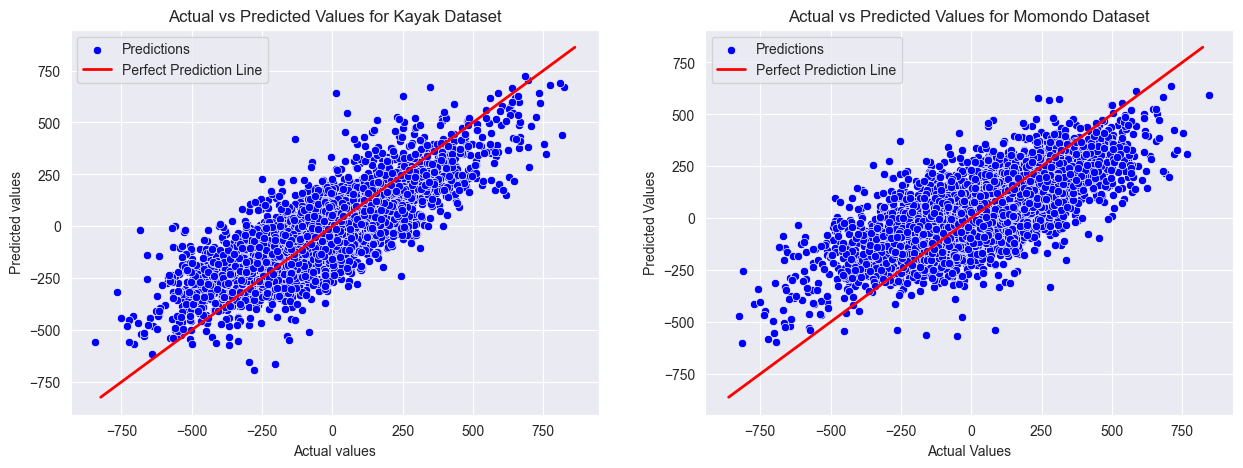

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Kayak Dataset
sns.scatterplot(x=y_testK, y=y_pred_kayak, color='blue', ax=axes[0], label='Predictions')
axes[0].plot([y_trainK.min(), y_trainK.max()], [y_trainK.min(), y_trainK.max()], color='red', lw=2, label='Perfect Prediction Line')
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Actual vs Predicted Values for Kayak Dataset')
axes[0].legend()
axes[0].grid(True)

# Momondo Dataset
sns.scatterplot(x=y_testM, y=y_pred_momo, color='blue', ax=axes[1], label='Predictions')
axes[1].plot([y_trainM.min(), y_trainM.max()], [y_trainM.min(), y_trainM.max()], color='red', lw=2, label='Perfect Prediction Line')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs Predicted Values for Momondo Dataset')
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.show()

## **Summary of Results:**
___
### **Comparison of Sites**

1️⃣ The Price Difference Is More Predictable for One Site:
- Even though both sites have the same features, the relationship between those features and the price difference is stronger for Kayak than Momondo.
- This suggests that the price differences on Kayak follow a clearer pattern, making it easier for the model to predict them.
- On Momondo, the price differences may be more random, meaning the same flight characteristics lead to more inconsistent price differences, reducing predictability.

2️⃣ Higher Noise & Volatility on the Lower-Scoring Site:
- If one site applies more dynamic pricing strategies, including sudden price changes, promotions, or personalized pricing, this would introduce more noise in the price difference.
- Since these fluctuations are not captured in the features, the model struggles to explain the price differences, resulting in lower scores.

### **Limited Scoring**
#### Explaining the Drop in Scores vs Price Prediction:
Flight prices themselves are influenced by well-known factors (e.g., airline, route, time to departure, demand trends).  
However, price differences between two sites can be highly volatile:  
- One site may have flash discounts, dynamic markups, or hidden fees that the other doesn’t.
- Sites may update prices at slightly different times, creating fluctuations.
- This extra randomness makes price differences harder to predict than flight prices themselves.
---

## **Final Thoughts**
✅ Our features may explain general flight pricing trends, but not site-specific pricing strategies.  
  
✅ Site-specific discounts, fees, and update timing create unpredictable variations.  
  
✅ Due to poor estimating of price differences between the sites, we will test the overall differences to get a clearer clue of the trends.

# Exploratory Data Analysis

After applying different models and trying to predict the price difference between the two websites,  
we can inspect the overall difference in price by comparing our data based on different features. 

In this section, we visualize key variables and examine their impact on price.  
We will explore trends, distributions, and relationships between features to gain insights into pricing patterns.
___


In [ ]:
data_copy = pd.get_dummies(data_copy, columns=['Site'], prefix='Site')

print(data_copy[['Site_Kayak', 'Site_Momondo']].head())  

   Site_Kayak  Site_Momondo
0        True         False
1        True         False
2        True         False
3        True         False
4        True         False


In [ ]:
# calculating avg price for each route (origin-destination) by site
avg_prices = data_copy.groupby(["Origin", "Destination"])["Price(NIS)"].mean().reset_index()

# creating a Pivot table for comparisons 
pivot_prices = data_copy.pivot_table(index=["Origin", "Destination"], 
                                     values="Price(NIS)", 
                                     columns=["Site_Kayak"], 
                                     aggfunc="mean")

# renaming column names for easier understanding
pivot_prices.columns = ["Momondo Price" if col == 0 else "Kayak Price" for col in pivot_prices.columns]

# calculating avg price difference between the sites for each route 
if "Kayak Price" in pivot_prices.columns and "Momondo Price" in pivot_prices.columns:
    pivot_prices["Price Diff"] = pivot_prices["Kayak Price"] - pivot_prices["Momondo Price"]

pivot_prices.reset_index(inplace=True)
print(pivot_prices)


   Origin Destination  Momondo Price  Kayak Price  Price Diff
0  London       Paris     432.808814   416.972133  -15.836681
1  London        Rome     684.678102   655.423119  -29.254983
2   Paris      London     433.616678   415.122300  -18.494378
3   Paris        Rome     700.960781   651.763991  -49.196790
4    Rome      London     702.721535   665.486588  -37.234947
5    Rome       Paris     713.152056   662.682011  -50.470046


## 🛫 Flight Price Comparison - Summary

- **Kayak prices are consistently lower** than Momondo across all routes.
- The largest price difference is on the **Rome → Paris** route (~50 NIS).
- The smallest price difference is on the **London → Paris** route (~15 NIS).
- **Possible reasons**:  
  - Different pricing algorithms between the platforms.  
  - Variations in demand and supply dynamics.  
  - Exclusive airline deals or promotions.  
  - Time-based fluctuations in fare updates.

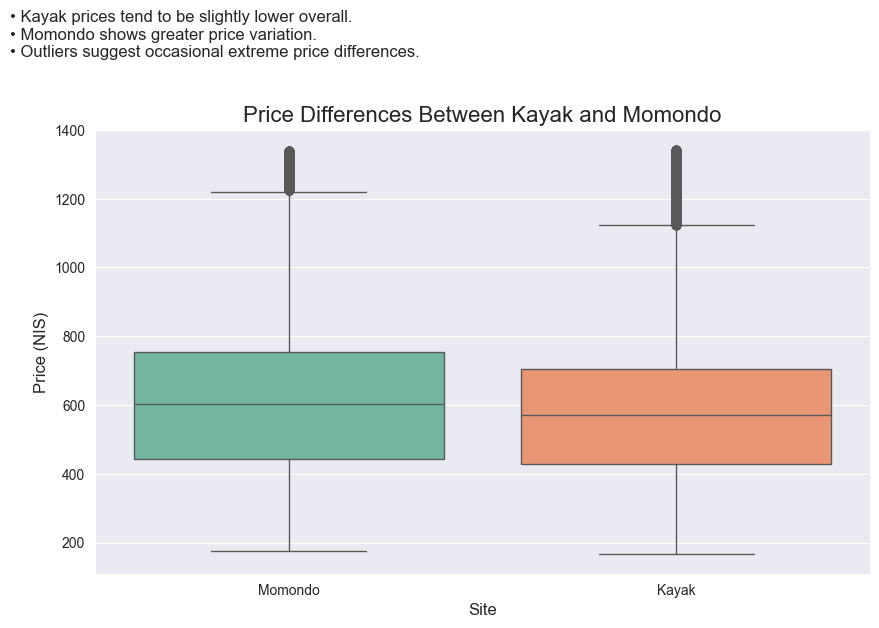

In [ ]:
#visualize price differences between Kayak and Momondo
plt.figure(figsize=(10, 6))
sns.boxplot(x="Site_Kayak", y="Price(NIS)", data=data_copy, palette="Set2")

plt.title("Price Differences Between Kayak and Momondo", fontsize=16)
plt.xlabel("Site", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

plt.xticks([0, 1], ['Momondo', 'Kayak'])

conclusions = (
    "• Kayak prices tend to be slightly lower overall.\n"
    "• Momondo shows greater price variation.\n"
    "• Outliers suggest occasional extreme price differences."
)

# Add the conclusions as text inside the plot
plt.subplots_adjust(top=0.85)  # Adjust the figure to make space for the text
plt.figtext(0.04, 1.05, conclusions, fontsize=12, ha='left', va='top')
plt.show()

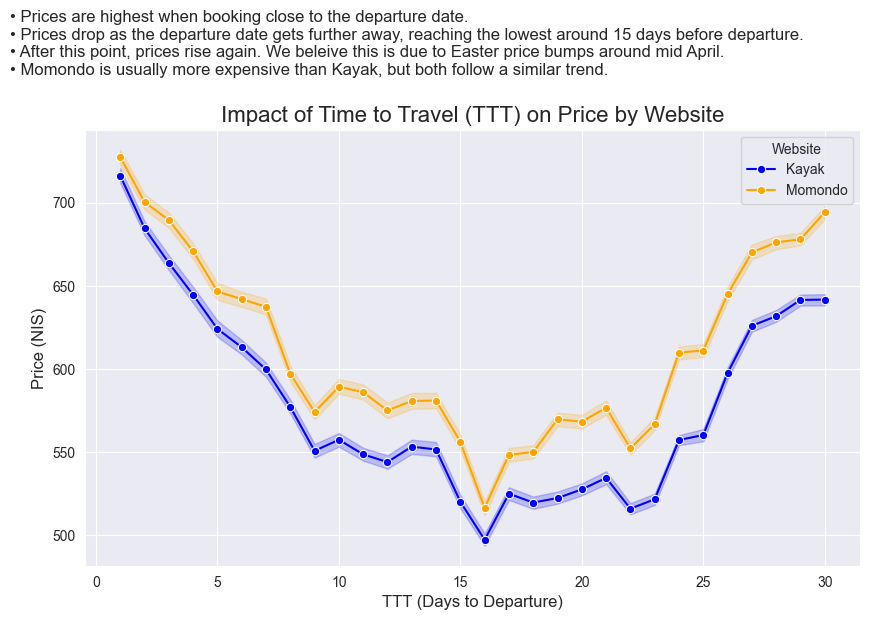

In [ ]:
# Set figure size
plt.figure(figsize=(10, 4))

# Line plot: Average prices for each TTT value, separated by website
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], x="TTT", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue")  # Kayak = Blue

sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], x="TTT", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange")  # Momondo = Orange

# Add conclusions above the title
conclusions = (
    "• Prices are highest when booking close to the departure date.\n"
    "• Prices drop as the departure date gets further away, reaching the lowest around 15 days before departure.\n"
    "• After this point, prices rise again. We beleive this is due to Easter price bumps around mid April.\n"
    "• Momondo is usually more expensive than Kayak, but both follow a similar trend."
)

# Adjust the figure layout to accommodate the text
plt.subplots_adjust(top=1.2)  
plt.figtext(0.05, 1.50, conclusions, fontsize=12, ha='left', va='top')

# Graph styling
plt.title("Impact of Time to Travel (TTT) on Price by Website", fontsize=16)
plt.xlabel("TTT (Days to Departure)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

# Update legend for clarity
plt.legend(title="Website")

# Display the plot
plt.show()


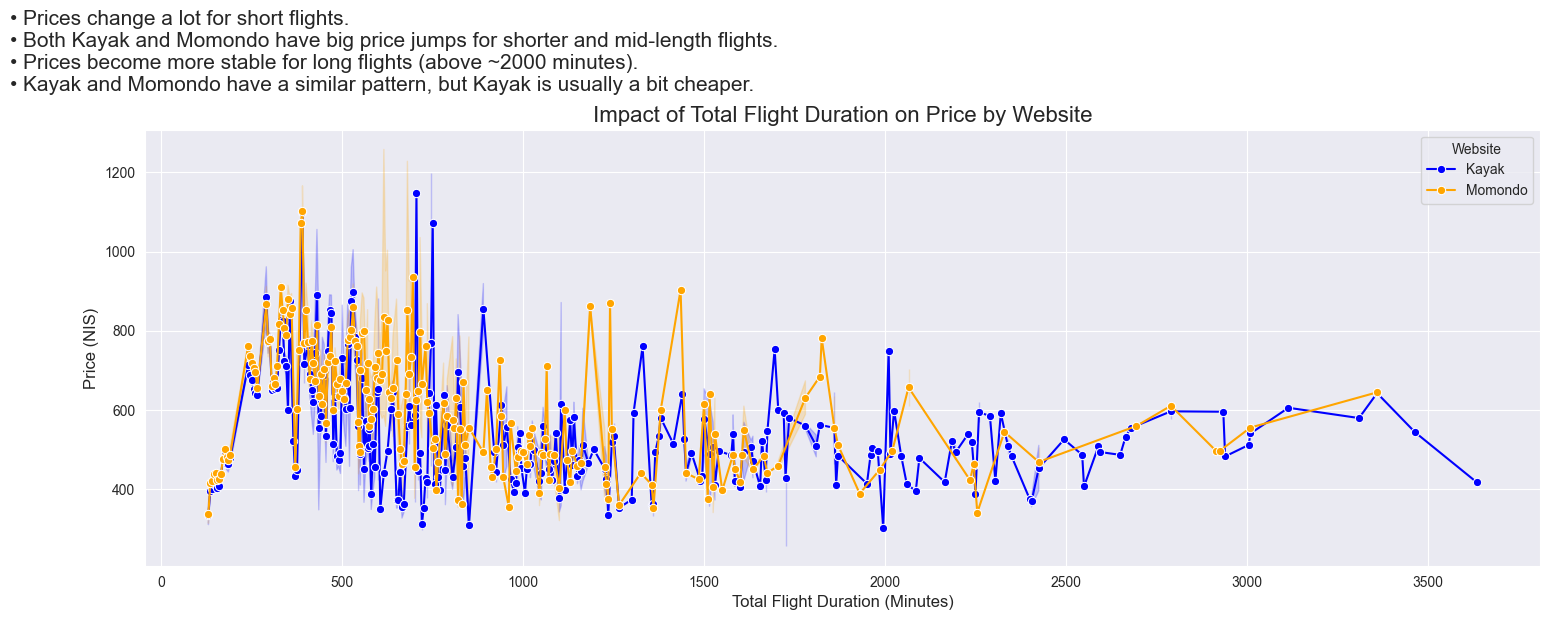

In [ ]:
# Set figure size
plt.figure(figsize=(18, 4))

# Line plot: Average prices for each total flight duration value, separated by website
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], x="Total Flight Duration(min)", 
             y="Price(NIS)", label="Kayak", marker="o", color="blue")  # Kayak = Blue

sns.lineplot(data=data_copy[data_copy["Site_Momondo"] == 1], x="Total Flight Duration(min)", 
             y="Price(NIS)", label="Momondo", marker="o", color="orange")  # Momondo = Orange

# Graph styling
plt.title("Impact of Total Flight Duration on Price by Website", fontsize=16)
plt.xlabel("Total Flight Duration (Minutes)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)

# Update the legend for better readability
plt.legend(title="Website")

# Add conclusions above the title
conclusions = (
    "• Prices change a lot for short flights.\n"
    "• Both Kayak and Momondo have big price jumps for shorter and mid-length flights.\n"
    "• Prices become more stable for long flights (above ~2000 minutes).\n"
    "• Kayak and Momondo have a similar pattern, but Kayak is usually a bit cheaper."
)

# Adjust the figure to make space for the text and place the text at the left side
plt.subplots_adjust(top=1.2)  
plt.figtext(0.05, 1.5, conclusions, fontsize=15, ha='left', va='top')

# Display the plot
plt.show()

In [ ]:
# Compute descriptive statistics for both websites in a single step
price_stats = data_copy.groupby("Site_Kayak")["Price(NIS)"].describe().T.round(2)

# Rename columns for clarity (0 = Momondo, 1 = Kayak)
price_stats.columns = ["Momondo", "Kayak"]

# Display the stats
display(price_stats)

,Momondo,Kayak
count,261896.00,265336.00
mean,611.50,578.10
std,215.52,197.59
min,174.00,168.00
25%,444.00,427.00
50%,603.00,571.00
75%,755.00,706.00
max,1339.00,1342.00


## Handling Data Imbalance Between Kayak and Momondo  
The dataset contains slightly more flights from **Kayak** than from **Momondo**.  
This could potentially impact our price difference prediction model if one site is overrepresented.  

### ** Should We Balance the Data?**  
In general we would either provide more data to even out the imbalance or clone records for the imbalanced site.  
Since the difference in flight counts is very minor, we will not modify the dataset for now.  
_______________________________

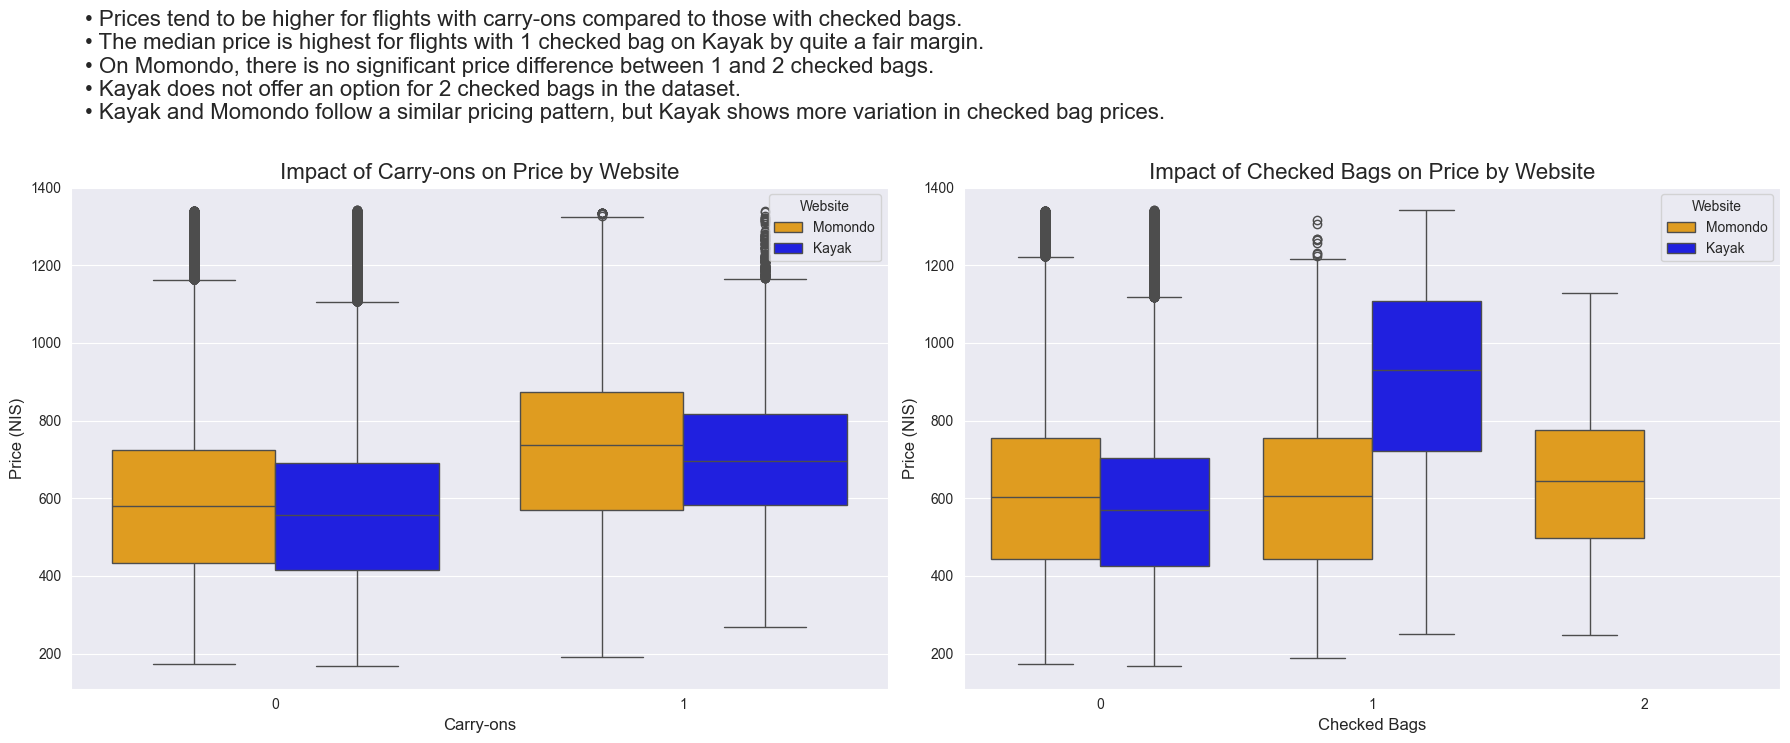

In [ ]:
# Convert NaN values to 0 and change data type to integer
data_copy["Carry-ons"] = data_copy["Carry-ons"].fillna(0).astype(int)
data_copy["Checked Bags"] = data_copy["Checked Bags"].fillna(0).astype(int)

# Define colors for consistency in the legend
palette = {"Kayak": "blue", "Momondo": "orange"}

# Set figure size with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot for Carry-ons impact on price by website
sns.boxplot(data=data_copy, x="Carry-ons", y="Price(NIS)", hue="Site_Kayak", 
            palette={1: palette["Kayak"], 0: palette["Momondo"]}, ax=axes[0])

# Styling for Carry-ons plot
axes[0].set_title("Impact of Carry-ons on Price by Website", fontsize=16)
axes[0].set_xlabel("Carry-ons", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)

# Fix legend colors
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ["Momondo", "Kayak"], title="Website")

# Boxplot for Checked Bags impact on price by website
sns.boxplot(data=data_copy, x="Checked Bags", y="Price(NIS)", hue="Site_Kayak", 
            palette={1: palette["Kayak"], 0: palette["Momondo"]}, ax=axes[1])

# Styling for Checked Bags plot
axes[1].set_title("Impact of Checked Bags on Price by Website", fontsize=16)
axes[1].set_xlabel("Checked Bags", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)

# Fix legend colors
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ["Momondo", "Kayak"], title="Website")

# Add conclusions above the title
conclusions = (
    "• Prices tend to be higher for flights with carry-ons compared to those with checked bags.\n"
    "• The median price is highest for flights with 1 checked bag on Kayak by quite a fair margin.\n"
    "• On Momondo, there is no significant price difference between 1 and 2 checked bags.\n"
    "• Kayak does not offer an option for 2 checked bags in the dataset.\n"
    "• Kayak and Momondo follow a similar pricing pattern, but Kayak shows more variation in checked bag prices."
)

plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.23, conclusions, fontsize=16, ha='left', va='top')

plt.tight_layout()
plt.show()


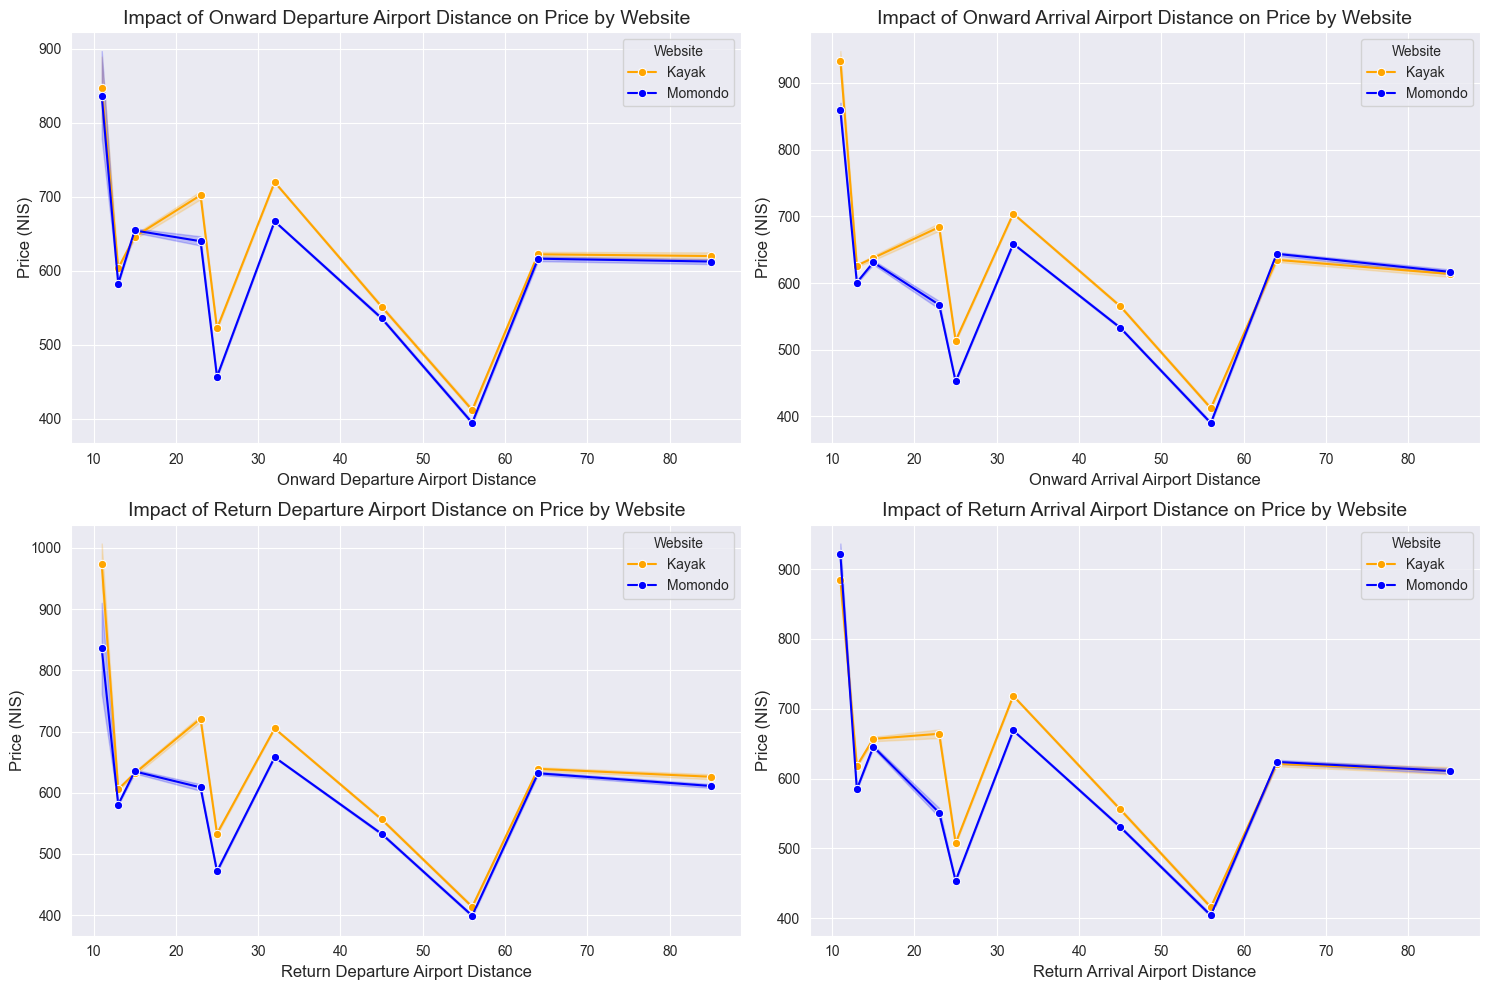

In [ ]:
# Set up subplots for the distance columns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define the distance columns
distance_columns = [
    "Onward Departure Airport Distance",
    "Onward Arrival Airport Distance",
    "Return Departure Airport Distance",
    "Return Arrival Airport Distance"
]

# Define colors for consistency
colors = {1: "blue", 0: "orange"}

# Iterate over distance columns and create plots
for ax, col in zip(axes.flat, distance_columns):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    # Styling
    ax.set_title(f"Impact of {col} on Price by Website", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Price (NIS)", fontsize=12)

    # Fix legend colors manually
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

plt.tight_layout()
plt.show()


## Impact of Airport Distance on Flight Prices

**Main Observations**
- Prices **change a lot** when the airport is **closer** (10-30 km).
- There is a **big drop** in prices around 50 km.
- Prices **stay more stable** for flights departing from airports 60 km or farther.
- **Kayak and Momondo show similar trends**, but Kayak has **slightly higher peaks**.
- After **60 km**, distance **doesn't seem to affect price much**.

**Why does this happen?**
- **Shorter flights** might cost more because of **higher demand or airport fees**.
- The **drop at 50 km** could mean airlines change their pricing rules at this distance.
- For **longer distances**, other factors (like demand and airline policies) may be more important than distance.

_________________

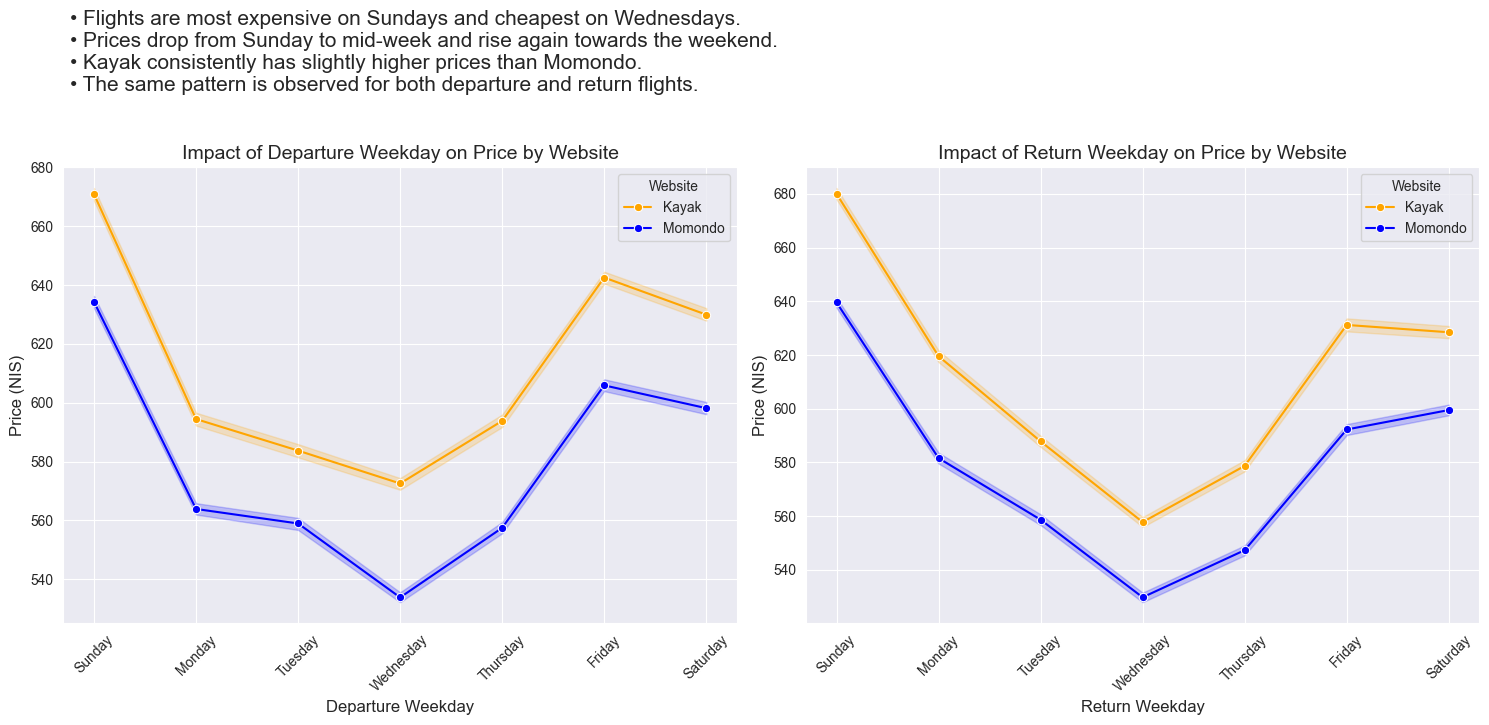

In [ ]:
# Set up subplots for Departure and Return Weekdays
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define the weekday columns
weekday_columns = ["Departure Weekday", "Return Weekday"]

# Define colors for consistency
colors = {1: "blue", 0: "orange"}

weekday_names = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Iterate over the weekday columns and create plots
for ax, col in zip(axes, weekday_columns):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    
    ax.set_title(f"Impact of {col} on Price by Website", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Price (NIS)", fontsize=12)

    ax.set_xticks(range(7))
    ax.set_xticklabels(weekday_names, rotation=45)

    # Fix legend colors manually
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

conclusions = (
    "• Flights are most expensive on Sundays and cheapest on Wednesdays.\n"
    "• Prices drop from Sunday to mid-week and rise again towards the weekend.\n"
    "• Kayak consistently has slightly higher prices than Momondo.\n"
    "• The same pattern is observed for both departure and return flights."
)

# Adjust layout to make space for text
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.2, conclusions, fontsize=15, ha='left', va='top')

# Display the plots
plt.tight_layout()
plt.show()


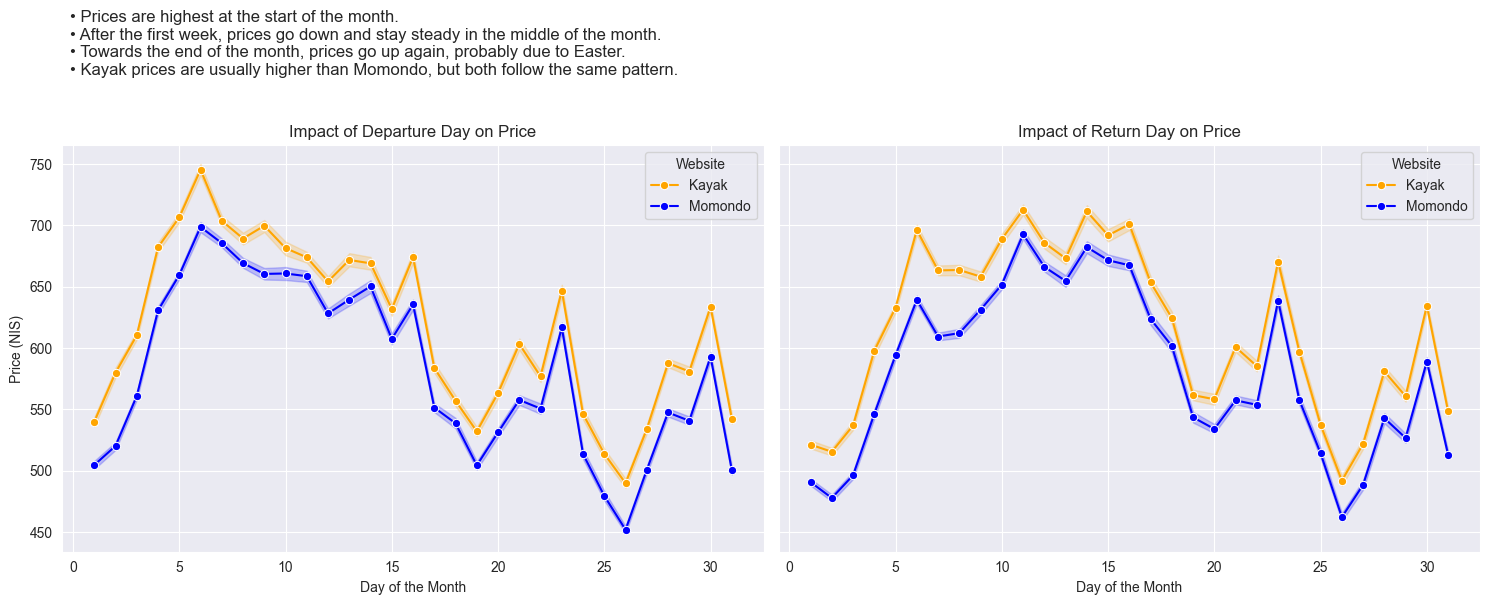

In [ ]:
# List of variables to display
day_columns = ["Departure Day", "Return Day"]

# Create a figure with 2 subplots to show the impact of departure and return day on price
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Titles for the subplots
titles = ["Impact of Departure Day on Price", "Impact of Return Day on Price"]

# Define colors for each website
colors = {1: "blue", 0: "orange"}

# Generate each subplot
for ax, col, title in zip(axes, day_columns, titles):
    sns.lineplot(data=data_copy, x=col, y="Price(NIS)", hue="Site_Kayak", 
                 palette=colors, marker="o", ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Day of the Month")

    # Fix legend: Change labels from True/False to Kayak/Momondo
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Kayak", "Momondo"], title="Website")

# Add a shared Y-label
axes[0].set_ylabel("Price (NIS)")

# Add conclusions above the plots
conclusions = (
    "• Prices are highest at the start of the month.\n"
    "• After the first week, prices go down and stay steady in the middle of the month.\n"
    "• Towards the end of the month, prices go up again, probably due to Easter.\n"
    "• Kayak prices are usually higher than Momondo, but both follow the same pattern."
)

# Adjust layout to make space for conclusions
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.2, conclusions, fontsize=12, ha='left', va='top')

# Display the plots
plt.tight_layout()
plt.show()


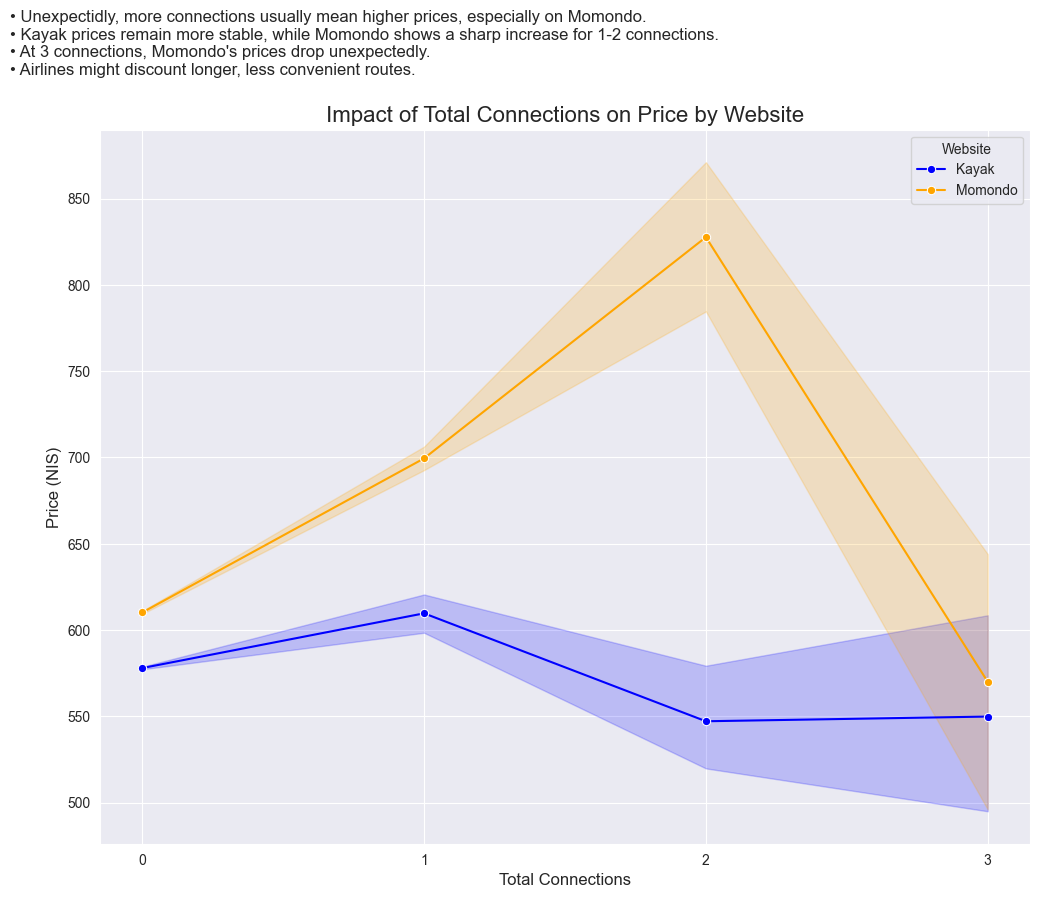

In [ ]:
# Set figure size for the Total Connections plot
plt.figure(figsize=(12, 6))

# Line plot for Kayak based on the Total Connections column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Total Connections", y="Price(NIS)", label="Kayak", marker="o", color="blue")

# Line plot for Momondo based on the Total Connections column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Total Connections", y="Price(NIS)", label="Momondo", marker="o", color="orange")

# Ensure x-axis only shows whole numbers (no decimals)
plt.xticks(np.arange(0, data_copy["Total Connections"].max() + 1, 1))

# Add conclusions above the title
conclusions = (
    "• Unexpectidly, more connections usually mean higher prices, especially on Momondo.\n"
    "• Kayak prices remain more stable, while Momondo shows a sharp increase for 1-2 connections.\n"
    "• At 3 connections, Momondo's prices drop unexpectedly.\n"
    "• Airlines might discount longer, less convenient routes."
)

# Adjust layout for text placement
plt.subplots_adjust(top=1.3)
plt.figtext(0.05, 1.5, conclusions, fontsize=12, ha='left', va='top')

# Styling
plt.title("Impact of Total Connections on Price by Website", fontsize=16)
plt.xlabel("Total Connections", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)
plt.legend(title="Website")

plt.show()

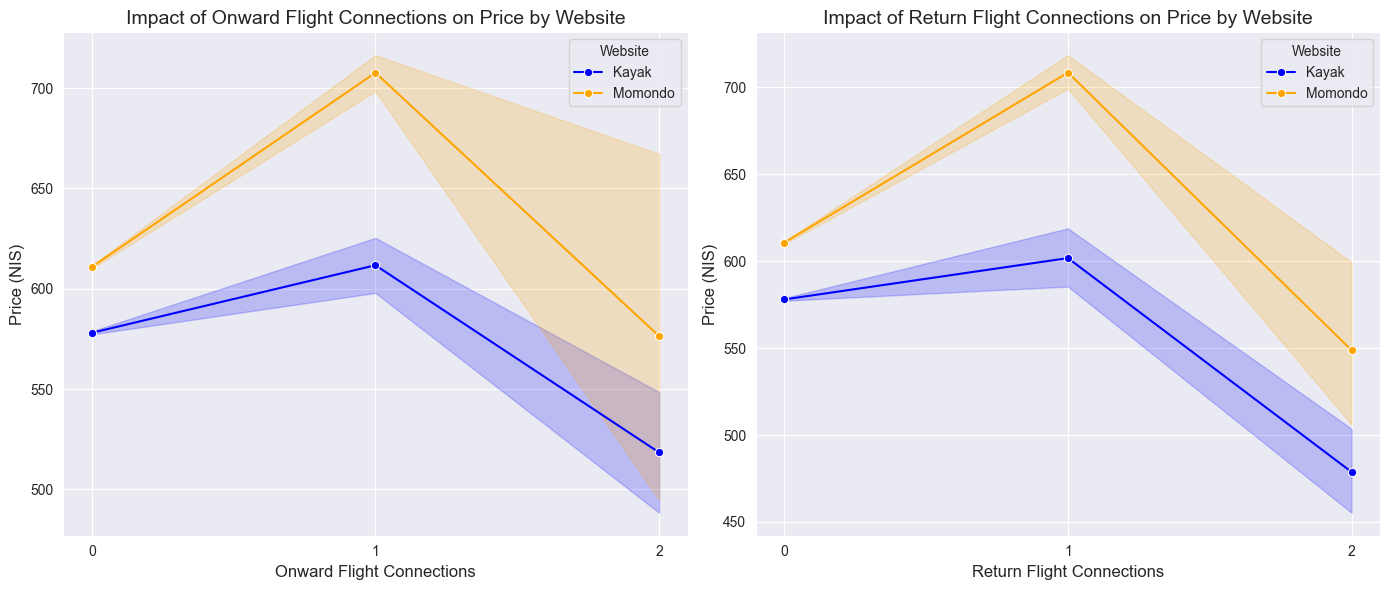

In [ ]:
# figure with two subplots (for Onward and Return Flight Connections)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Onward Flight Connections plot for Kayak and Momondo
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Onward Flight Connections", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue", ax=axes[0])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Onward Flight Connections", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange", ax=axes[0])

# Return Flight Connections plot for Kayak and Momondo
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Return Flight Connections", y="Price(NIS)", 
             label="Kayak", marker="o", color="blue", ax=axes[1])
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Return Flight Connections", y="Price(NIS)", 
             label="Momondo", marker="o", color="orange", ax=axes[1])

axes[0].set_title("Impact of Onward Flight Connections on Price by Website", fontsize=14)
axes[0].set_xlabel("Onward Flight Connections", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)
axes[0].legend(title="Website")

axes[1].set_title("Impact of Return Flight Connections on Price by Website", fontsize=14)
axes[1].set_xlabel("Return Flight Connections", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)
axes[1].legend(title="Website")

# Ensure X-axis displays only whole numbers (0, 1, 2)
axes[0].set_xticks([0, 1, 2])
axes[1].set_xticks([0, 1, 2])

plt.tight_layout()
plt.show()

In [ ]:
data_copy[['Onward Flight Connections', 'Return Flight Connections']].describe()

,Onward Flight Connections,Return Flight Connections
count,527232.000000,527232.000000
mean,0.005127,0.005280
std,0.072079,0.073488
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2.000000,2.000000


## Flight Connections & Price

- Prices rise with 1 connection but drop at 2 connections.  
- **No difference** between onward & return flights—same trend.  
- **Momondo is always pricier** than Kayak.  
- Most flights have 0 or 1 connection, keeping trends identical.  
- Low demand or small sample size may explain the 2-stop price drop.  
_______

In [ ]:
data_copy.columns

Index(['Origin', 'Destination', 'TTT', 'LOS', 'Arrival Time',
       'Return Arrival Time', 'Onward Departure Airport',
       'Onward Arrival Airport', 'Return Departure Airport',
       'Return Arrival Airport', 'Onward Airlines', 'Return Airlines',
       'Onward Flight Connections', 'Onward Connection Duration(min)',
       'Onward Flight Connection Airport', 'Return Flight Connections',
       'Return Connection Duration(min)', 'Return Flight Connection Airport',
       'Carry-ons', 'Checked Bags', 'Price(NIS)', 'Snapshot Date',
       'Total Onward Flight Duration(min)',
       'Total Return Flight Duration(min)', 'Departure Month', 'Departure Day',
       'Departure Weekday', 'Return Month', 'Return Day', 'Return Weekday',
       'Departure Time Category Num', 'Return Time Category Num',
       'Is Weekend Flight', 'Onward Departure Airport Distance',
       'Onward Arrival Airport Distance', 'Return Departure Airport Distance',
       'Return Arrival Airport Distance', 'Total C

In [ ]:
# Count the number of flights per route per website
route_counts = data_copy.groupby(["Origin", "Destination", "Site_Kayak"]).size().reset_index(name="Flight Count")

# Convert True/False to actual site names
route_counts["Site"] = route_counts["Site_Kayak"].map({True: "Kayak", False: "Momondo"})

# Pivot table to display flights per route for each website
route_counts_pivot = route_counts.pivot_table(index=["Origin", "Destination"], 
                                              columns="Site", 
                                              values="Flight Count", 
                                              aggfunc="sum").fillna(0)

route_counts_pivot.reset_index(inplace=True)
route_counts_pivot

Site,Origin,Destination,Kayak,Momondo
0,London,Paris,43815,43272
1,London,Rome,43678,43113
2,Paris,London,44399,43890
3,Paris,Rome,44939,44290
4,Rome,London,43840,43492
5,Rome,Paris,44665,43839


## Flight Counts per Route and Website

- Kayak and Momondo have a similar number of flights for each route, with slight variations.
- The busiest route is Paris - Rome, having the highest flight count.
- London - Paris and London - Rome are also popular routes, showing high flight frequencies.
- No significant dominance of one website over another in terms of flight availability.


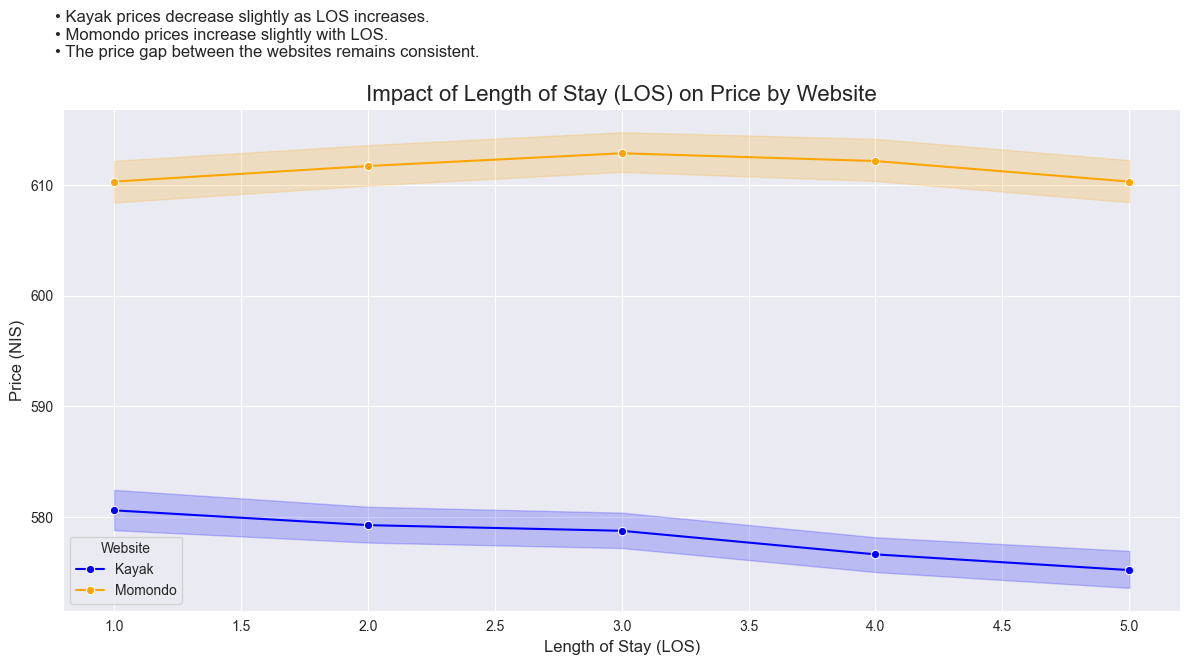

In [ ]:
# LOS plot
plt.figure(figsize=(12, 6))

# Line plot for Kayak based on the LOS column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="LOS", y="Price(NIS)", label="Kayak", marker="o", color="blue")

# Line plot for Momondo based on the LOS column
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="LOS", y="Price(NIS)", label="Momondo", marker="o", color="orange")

# Styling
plt.title("Impact of Length of Stay (LOS) on Price by Website", fontsize=16)
plt.xlabel("Length of Stay (LOS)", fontsize=12)
plt.ylabel("Price (NIS)", fontsize=12)
plt.legend(title="Website")

# Add conclusions above the graph
conclusions = (
    "• Kayak prices decrease slightly as LOS increases.\n"
    "• Momondo prices increase slightly with LOS.\n"
    "• The price gap between the websites remains consistent."
)

# Adjust layout for conclusions
plt.subplots_adjust(top=1.2)
plt.figtext(0.05, 1.1, conclusions, fontsize=12, ha='left', va='top')
plt.tight_layout()
plt.show()


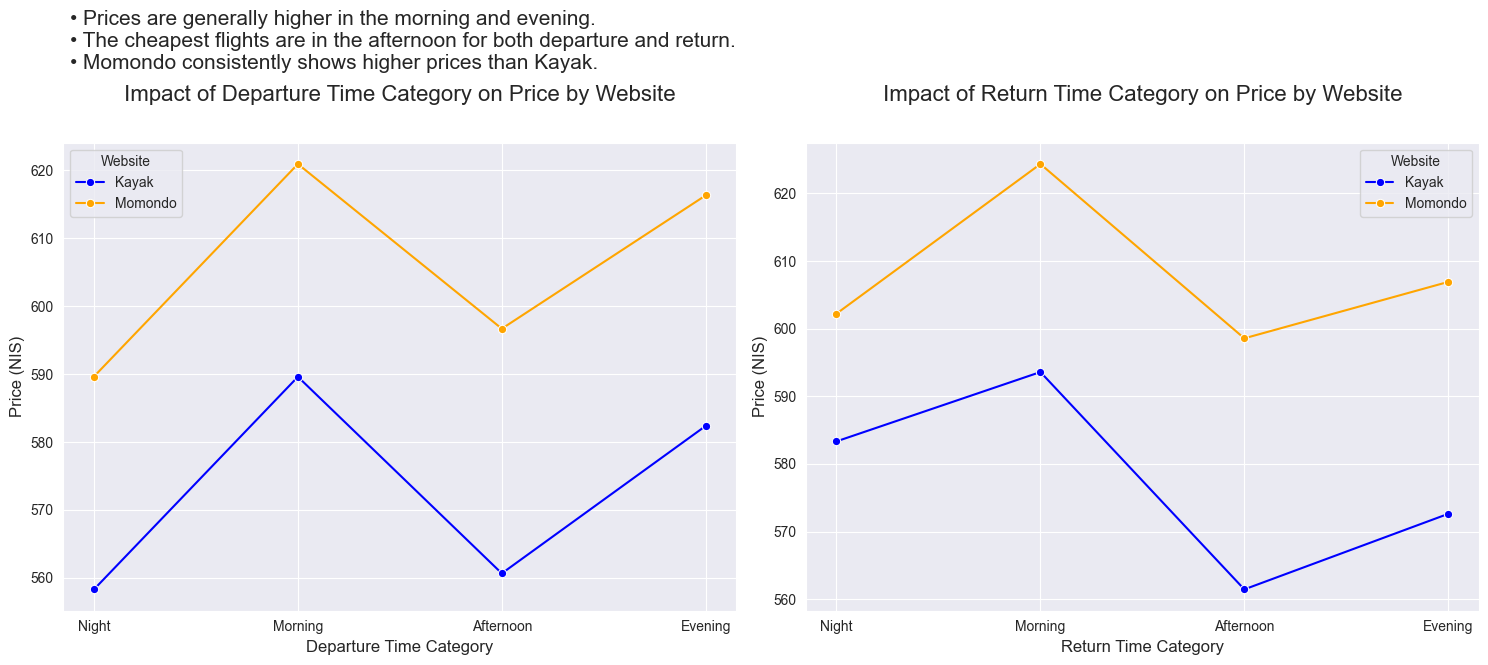

In [ ]:

# Define category labels
time_categories = {0: "Night", 1: "Morning", 2: "Afternoon", 3: "Evening"}

# Create subplots for Departure and Return Time Category
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Departure Time Category plot
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Departure Time Category Num", y="Price(NIS)", label="Kayak", 
             marker="o", color="blue", ax=axes[0], errorbar=None)
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Departure Time Category Num", y="Price(NIS)", label="Momondo", 
             marker="o", color="orange", ax=axes[0], errorbar=None)

# Customize the first subplot
axes[0].set_title("Impact of Departure Time Category on Price by Website", fontsize=16, pad=30)
axes[0].set_xlabel("Departure Time Category", fontsize=12)
axes[0].set_ylabel("Price (NIS)", fontsize=12)
axes[0].set_xticks(list(time_categories.keys()))
axes[0].set_xticklabels(list(time_categories.values()))
axes[0].legend(title="Website")

# Return Time Category plot
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 1], 
             x="Return Time Category Num", y="Price(NIS)", label="Kayak", 
             marker="o", color="blue", ax=axes[1], errorbar=None)
sns.lineplot(data=data_copy[data_copy["Site_Kayak"] == 0], 
             x="Return Time Category Num", y="Price(NIS)", label="Momondo", 
             marker="o", color="orange", ax=axes[1], errorbar=None)

# Customize the second subplot
axes[1].set_title("Impact of Return Time Category on Price by Website", fontsize=16, pad=30)
axes[1].set_xlabel("Return Time Category", fontsize=12)
axes[1].set_ylabel("Price (NIS)", fontsize=12)
axes[1].set_xticks(list(time_categories.keys()))
axes[1].set_xticklabels(list(time_categories.values()))
axes[1].legend(title="Website")

# Add conclusions above the plots
conclusions = (
    "• Prices are generally higher in the morning and evening.\n"
    "• The cheapest flights are in the afternoon for both departure and return.\n"
    "• Momondo consistently shows higher prices than Kayak."
)

# Adjust layout for conclusions
plt.subplots_adjust(top=1.2)
plt.figtext(0.05, 1.1, conclusions, fontsize=15, ha='left', va='top')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# **Price Differences Between Kayak and Momondo - Summary**

## **1️⃣ General Trends**
- Momondo is usually more expensive than Kayak, with greater price fluctuations.
- Kayak offers more stable pricing with fewer extreme variations.
- Significant price differences occur on weekends, during peak hours, and for flights with multiple connections.

---

## **2️⃣ Key Features Affecting Price Differences**
Below are the top 10 features with the strongest correlation to price differences:

### **🔼 Features Increasing Price Difference**
✔ **Return & Onward Airport Distances** – Longer distances lead to greater price gaps.  
✔ **Return Weekday** – The day of return slightly impacts price differences.  

### **🔽 Features Reducing Price Difference**
✔ **Departure & Return Days** – Some days have smaller price gaps.  
✔ **Length of Stay** – Longer stays slightly reduce price differences.  
✔ **Seasonal Effects** – Departure/return month has a minor role.  
✔ **Layover Duration** – Longer layovers tend to reduce price gaps.  

---

## **3️⃣ What Drives the Price Differences?**
📌 More connections increase prices, especially on Momondo.  
📌 Weekend flights (Friday-Sunday) are more expensive.  
📌 Morning and evening flights cost more, while afternoon flights are cheaper.  
📌 Long layovers may lead to lower price gaps.  
📌 Flight distance plays a major role in price differences.  

---

## **4️⃣ How This Helps Our Predictive Model**
🔹 Key features with high correlation will be used as predictors.  
🔹 Flight distance and timing variables will be prioritized.  
🔹 Categorical variables (weekends, time of day, layovers) will help capture non-linear effects.  
🔹 These insights guide feature selection and model choice for predicting price differences.  

---

## **📌 Key Takeaways**
✔ Momondo is usually more expensive, with greater fluctuations.  
✔ Kayak has more stable pricing, with fewer effects from layovers and stay duration.  
✔ Distance, layovers, and timing are major drivers of price differences.  
✔ These findings will help fine-tune our predictive model.  
